# Familiarity Bias Analysis

Analyze test set based on key contribution frequency in training set:
- **Target Material** (`Material_Name`)
- **Synthesis Method** (`process`)
- **Application Domain** (`domain`)

Split test set 50:50 into **Familiar** vs **Unfamiliar** groups.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Load Datasets

In [2]:
# Load train and test datasets
train = pd.read_parquet('/workspace/Materials_RL/open-materials-guide-2024/data/train-00000-of-00001.parquet')
test = pd.read_parquet('/workspace/Materials_RL/open-materials-guide-2024/data/test_high_impact-00000-of-00001.parquet')

print(f"Train set: {len(train)} samples")
print(f"Test set (high impact): {len(test)} samples")

Train set: 16026 samples
Test set (high impact): 169 samples


## 2. Count Key Contribution Frequencies in Training Set

In [3]:
# Key contribution columns
KEY_COLS = ['Material_Name', 'process', 'domain']

# Count frequencies in training set
train_freq = {}
for col in KEY_COLS:
    train_freq[col] = Counter(train[col].dropna())
    print(f"\n=== {col} (Top 10) ===")
    for item, count in train_freq[col].most_common(10):
        print(f"  {item}: {count}")


=== Material_Name (Top 10) ===
  Silver nanoparticles: 101
  Graphene: 96
  Molybdenum disulfide: 74
  Zinc oxide: 64
  Zinc oxide nanoparticles: 54
  Gold nanoparticles: 41
  Titanium dioxide: 40
  Silver Nanoparticles: 30
  Gallium Nitride: 26
  Hydroxyapatite: 26

=== process (Top 10) ===
  Hybrid: 6383
  Solution-Based: 2913
  Vapor Deposition: 1580
  Hydrothermal: 1334
  Solid-State: 1071
  Others: 695
  Electrochemical: 597
  Mechanochemical: 441
  Pyrolysis: 285
  Biological: 205

=== domain (Top 10) ===
  Energy: 4905
  Others: 4115
  Environmental: 2502
  Healthcare: 2248
  Electronics: 2200
  Aerospace: 11
  Energy, Electronics, Healthcare, Environmental: 3
  Environment: 3
  Energy  
Electronics  
Healthcare: 1
  Electronics, Energy: 1


## 2.1 Word Clouds - Training Set

Visualize keyword frequency distribution for Material, Synthesis Process, and Application Domain in the training set.

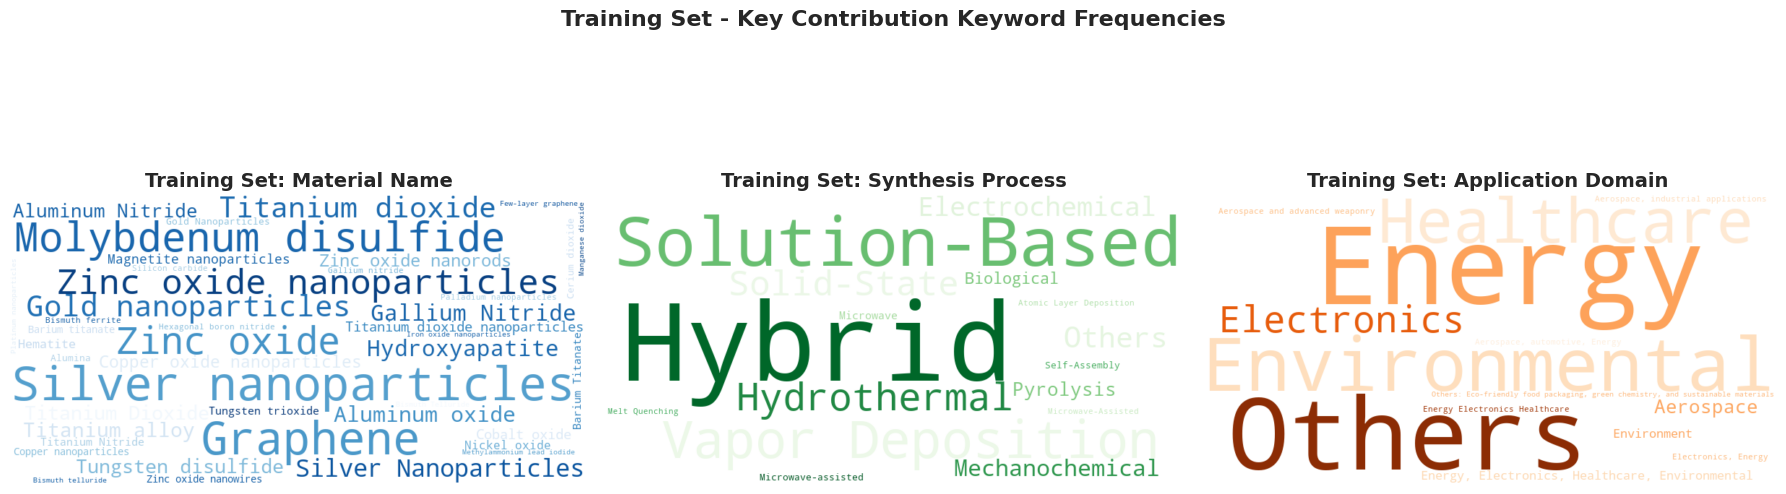

Training set unique counts:
  Materials: 13857
  Processes: 134
  Domains: 47


In [4]:
from wordcloud import WordCloud

def clean_text(text):
    """Clean text by removing newlines and extra whitespace."""
    if pd.isna(text):
        return text
    return ' '.join(str(text).replace('\n', ' ').replace('\r', ' ').split())

def generate_wordcloud(freq_dict, title, ax, colormap='viridis'):
    """Generate word cloud from frequency dictionary."""
    if not freq_dict:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=20)
        ax.set_title(title)
        ax.axis('off')
        return
    
    # Clean the frequency dict keys (remove newlines)
    clean_freq = {clean_text(k): v for k, v in freq_dict.items() if k}
    
    wc = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap=colormap,
        max_words=100,
        min_font_size=10,
        max_font_size=150,
        prefer_horizontal=0.9,
    ).generate_from_frequencies(clean_freq)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')

# Training Set Word Clouds
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Material Name
generate_wordcloud(dict(train_freq['Material_Name']), 'Training Set: Material Name', axes[0], 'Blues')

# Synthesis Process
generate_wordcloud(dict(train_freq['process']), 'Training Set: Synthesis Process', axes[1], 'Greens')

# Application Domain
generate_wordcloud(dict(train_freq['domain']), 'Training Set: Application Domain', axes[2], 'Oranges')

plt.suptitle('Training Set - Key Contribution Keyword Frequencies', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('wordcloud_train.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training set unique counts:")
print(f"  Materials: {len(train_freq['Material_Name'])}")
print(f"  Processes: {len(train_freq['process'])}")
print(f"  Domains: {len(train_freq['domain'])}")

## 2.2 Word Clouds - Test Set (High Impact)

Visualize keyword frequency distribution for Material, Synthesis Process, and Application Domain in the test set.

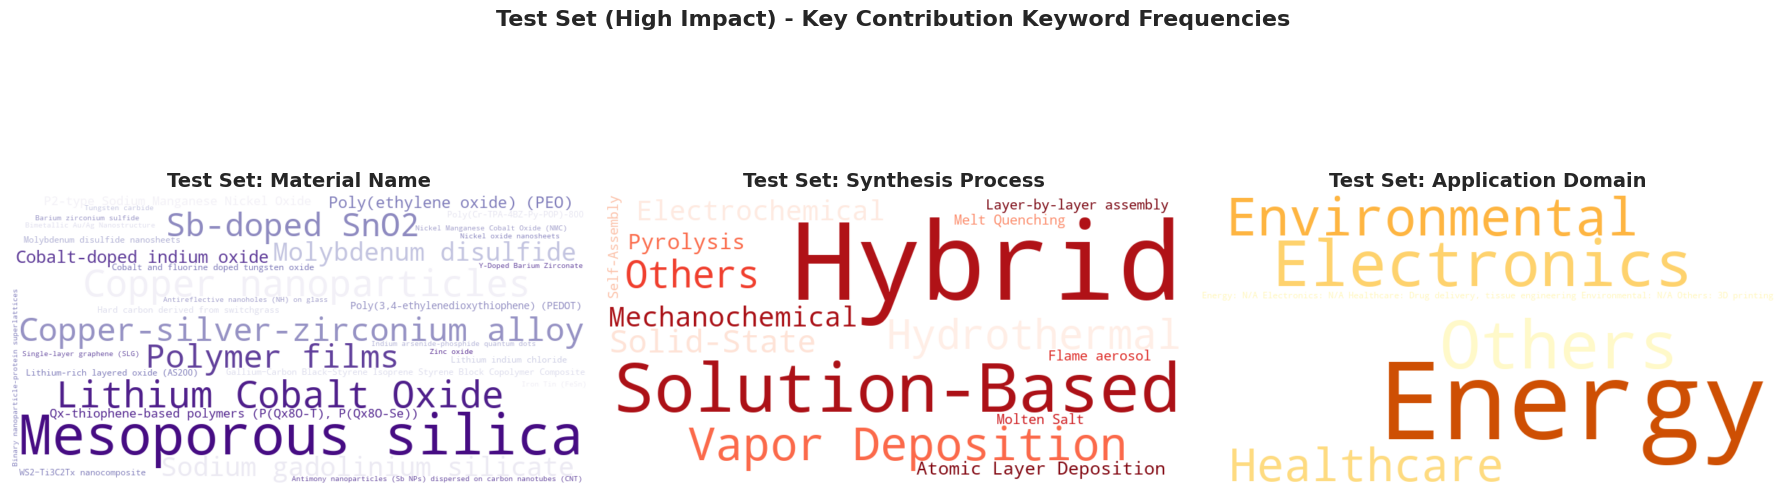

Test set unique counts:
  Materials: 167
  Processes: 15
  Domains: 6


In [5]:
# Count frequencies in test set
test_freq = {}
for col in KEY_COLS:
    test_freq[col] = Counter(test[col].dropna())

# Test Set Word Clouds
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Material Name
generate_wordcloud(dict(test_freq['Material_Name']), 'Test Set: Material Name', axes[0], 'Purples')

# Synthesis Process
generate_wordcloud(dict(test_freq['process']), 'Test Set: Synthesis Process', axes[1], 'Reds')

# Application Domain
generate_wordcloud(dict(test_freq['domain']), 'Test Set: Application Domain', axes[2], 'YlOrBr')

plt.suptitle('Test Set (High Impact) - Key Contribution Keyword Frequencies', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('wordcloud_test.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Test set unique counts:")
print(f"  Materials: {len(test_freq['Material_Name'])}")
print(f"  Processes: {len(test_freq['process'])}")
print(f"  Domains: {len(test_freq['domain'])}")

## 3. Compute Familiarity Score for Test Set

Familiarity score = sum of training frequencies for each key contribution

In [12]:
import math
from collections import Counter
import pandas as pd

def compute_familiarity_score(row, train_freq, key_cols):
    """Compute familiarity score based on training set frequency."""
    score = 0
    details = {}
    
    for col in key_cols:
        value = row[col]
        freq = train_freq[col].get(value, 0) if pd.notna(value) else 0
        details[col] = freq
        score += freq
    
    return score, details

def compute_familiarity_score_scaled(row, train_freq, train_pct, key_cols):
    """Familiarity = mean(percentile(freq(value)) over columns)."""
    score_sum = 0.0
    n = 0
    details = {}

    for col in key_cols:
        v = row[col]
        if pd.isna(v):
            details[col] = {"freq": 0, "pct": None}
            continue

        freq = train_freq[col].get(v, 0)
        pct = train_pct[col].get(v, 0.0)  # OOV는 0으로 처리
        details[col] = {"freq": freq, "pct": pct}

        score_sum += pct
        n += 1

    score = score_sum / n if n > 0 else float("nan")
    return score, details

def familiarity_logprob(row, train_counts, col_stats, key_cols, alpha=1.0, eps=1e-12):
    # train_counts[col]: dict(value -> count)
    # col_stats[col] = {"N": total_nonnull_count, "K": num_unique_values}
    scores = {}
    for col in key_cols:
        v = row[col]
        if pd.isna(v):
            scores[col] = None
            continue
        cnt = train_counts[col].get(v, 0)
        N = col_stats[col]["N"]
        K = col_stats[col]["K"]
        p = (cnt + alpha) / (N + alpha * K)
        scores[col] = math.log(p + eps)  # 값이 클수록 더 익숙
    # 결측은 평균에서 제외(또는 별도 처리)
    vals = [s for s in scores.values() if s is not None]
    return (sum(vals) / len(vals) if vals else float("-inf")), scores


# 빈도 (value -> count)
train_freq = {col: Counter(train[col].dropna()) for col in KEY_COLS}

# 퍼센타일 (value -> [0,1])  : 가장 희귀=0, 가장 흔함=1
train_pct = {}
for col in KEY_COLS:
    s = pd.Series(train_freq[col], dtype=float)  # index=value, value=count
    if len(s) == 0:
        train_pct[col] = {}
    elif len(s) == 1:
        train_pct[col] = {s.index[0]: 1.0}
    else:
        r = s.rank(method="average")              # 1..n (count가 클수록 rank 큼)
        pct = (r - 1) / (len(r) - 1)              # 0..1
        train_pct[col] = pct.to_dict()

# Compute scores for test set
test_scores = []
# train_counts = {col: Counter(train[col].dropna()) for col in KEY_COLS}
# col_stats = {col: {"N": train[col].notna().sum(), "K": train[col].nunique()} for col in KEY_COLS}
for idx, row in test.iterrows():
    # score, details = compute_familiarity_score(row, train_freq, KEY_COLS)
    score, details = compute_familiarity_score_scaled(row, train_freq, train_pct, KEY_COLS)
    test_scores.append({
        'id': row['id'],
        'Material_Name': row['Material_Name'],
        'process': row['process'],
        'domain': row['domain'],
        'familiarity_score': score,
        'material_pct': details['Material_Name']['pct'],
        'process_pct': details['process']['pct'],
        'domain_pct': details['domain']['pct'],
        'material_freq': details['Material_Name']['freq'],
        'process_freq': details['process']['freq'],
        'domain_freq': details['domain']['freq'],
    })


test_df = pd.DataFrame(test_scores)
test_df = test_df.sort_values('familiarity_score', ascending=False).reset_index(drop=True)

print(f"Test samples: {len(test_df)}")
print(f"\nFamiliarity score range: {test_df['familiarity_score'].min()} - {test_df['familiarity_score'].max()}")
print(f"Mean: {test_df['familiarity_score'].mean():.1f}, Median: {test_df['familiarity_score'].median():.1f}")

Test samples: 169

Familiarity score range: 0.3333333333333333 - 0.9993745188606621
Mean: 0.7, Median: 0.7


In [13]:
# Show top 10 most familiar
print("=== Top 10 Most Familiar (High Training Frequency) ===")
test_df.head(10)

=== Top 10 Most Familiar (High Training Frequency) ===


,id,Material_Name,process,domain,familiarity_score,material_pct,process_pct,domain_pct,material_freq,process_freq,domain_freq
0,eedccb471a5626725666439865a6c568b977761a,Copper nanoparticles,Hybrid,Energy,0.999375,0.998124,1.000000,1.000000,12,6383,4905
1,7f08f2d04325686e82eca3218c606393ca8ba72f,Methylammonium lead iodide,Hybrid,Energy,0.999074,0.997221,1.000000,1.000000,10,6383,4905
2,d90e0bfbd70951dfa86160777ca42b8b5aeefbcf,Zinc oxide,Vapor Deposition,Energy,0.994915,0.999783,0.984962,1.000000,64,1580,4905
3,a167bcaf198b8d014b66f726f5512fb91dea9f9a,Tungsten diselenide,Solution-Based,Energy,0.994090,0.989788,0.992481,1.000000,4,2913,4905
4,6125d104918f2423324a6fe90f29e350bf21729c,"Cobalt(II,III) oxide",Solution-Based,Energy,0.992093,0.983798,0.992481,1.000000,3,2913,4905
5,7c9e3e02b219d4577b014b1f6d469dff6805e220,Borophene,Hybrid,Energy,0.987935,0.963806,1.000000,1.000000,2,6383,4905
6,840c42959e20db491a589bf06b7ad3b486352aee,Single-layer graphene (SLG),Hybrid,Energy,0.987935,0.963806,1.000000,1.000000,2,6383,4905
7,622f5c210467adcf07f06afb7754dc37491a1851,Tungsten carbide,Solution-Based,Energy,0.985429,0.963806,0.992481,1.000000,2,2913,4905
8,89aeb9422ce226e2bf657612a55a7d93e017e87f,Silver selenide,Solution-Based,Energy,0.985429,0.963806,0.992481,1.000000,2,2913,4905
9,310e8c8c5aeae38f33f77ca5ff3e6994dcc1484b,Magnetite nanoparticles,Hybrid,Environmental,0.985050,0.998629,1.000000,0.956522,16,6383,2502


In [14]:
# Show top 10 least familiar
print("=== Top 10 Least Familiar (Low Training Frequency) ===")
test_df.tail(10)

=== Top 10 Least Familiar (Low Training Frequency) ===


,id,Material_Name,process,domain,familiarity_score,material_pct,process_pct,domain_pct,material_freq,process_freq,domain_freq
159,a37669bd166f418372d9ef861818572b884d8a29,Bismuth oxychalcogenide,Vapor Deposition,Electronics,0.632669,0.0,0.984962,0.913043,0,1580,2200
160,055d97c6f73a66cdf30e92cc06f2cfc4da5ad4fc,Graphene glass fiber fabric (GGFF),Vapor Deposition,Electronics,0.632669,0.0,0.984962,0.913043,0,1580,2200
161,9fe52cb9c826a5a3755da812b31e5c0c873281a2,NIPX%-Covalent Organic Frameworks (COFs),Hydrothermal,Electronics,0.630162,0.0,0.977444,0.913043,0,1334,2200
162,c96e56de973b4c389c136b6267a4fb8495e30b91,Onion-like multicolor thermally activated dela...,Hydrothermal,Electronics,0.630162,0.0,0.977444,0.913043,0,1334,2200
163,109468097369bdea4078dfb839d45446f0067b02,Nickel-rich Lithium Nickel Manganese Cobalt Ox...,Atomic Layer Deposition,Energy,0.629073,0.0,0.887218,1.000000,0,32,4905
164,3fb1ba80a55ae164cc31ffcce1c7d343f5d53bb6,PEG-functionalized Rh(II)-based cuboctahedral ...,Melt Quenching,Others,0.624333,0.0,0.894737,0.978261,0,35,4115
165,2a09761d4cac61d4fa5622d5401c5574368cda9f,Single-crystalline lithium nickel oxide,Molten Salt,Energy,0.619048,0.0,0.857143,1.000000,0,10,4905
166,5f89eda4d04bc84147009e829a8c5472030c72ae,Amorphous boron nitride,Atomic Layer Deposition,Electronics,0.600087,0.0,0.887218,0.913043,0,32,2200
167,36bb8f31be3767c837506365709b01f1ba1f9304,Nickel-based ceramic solid solution nanoshells,Flame aerosol,Energy,0.333333,0.0,0.000000,1.000000,0,0,4905
168,9357e5e145141ebf26a5ac88eae1bd1e3a7ff9e7,"Polymeric, metallic, and composite parts",Hybrid,Energy: N/A \n Electronics: N/A \n Healt...,0.333333,0.0,1.000000,0.000000,0,6383,0


## 4. Split 50:50 into Familiar vs Unfamiliar Groups

In [15]:
# Split at median
n_samples = len(test_df)
split_idx = n_samples // 2

familiar_df = test_df.iloc[:split_idx].copy()
unfamiliar_df = test_df.iloc[split_idx:].copy()

familiar_df['group'] = 'Familiar'
unfamiliar_df['group'] = 'Unfamiliar'

print(f"Familiar group: {len(familiar_df)} samples")
print(f"  Score range: {familiar_df['familiarity_score'].min()} - {familiar_df['familiarity_score'].max()}")
print(f"  Mean score: {familiar_df['familiarity_score'].mean():.1f}")
print()
print(f"Unfamiliar group: {len(unfamiliar_df)} samples")
print(f"  Score range: {unfamiliar_df['familiarity_score'].min()} - {unfamiliar_df['familiarity_score'].max()}")
print(f"  Mean score: {unfamiliar_df['familiarity_score'].mean():.1f}")

Familiar group: 84 samples
  Score range: 0.6594202898550724 - 0.9993745188606621
  Mean score: 0.8

Unfamiliar group: 85 samples
  Score range: 0.3333333333333333 - 0.6594202898550724
  Mean score: 0.6


In [16]:
# Combine for visualization
combined_df = pd.concat([familiar_df, unfamiliar_df], ignore_index=True)
combined_df

,id,Material_Name,process,domain,familiarity_score,material_pct,process_pct,domain_pct,material_freq,process_freq,domain_freq,group
0,eedccb471a5626725666439865a6c568b977761a,Copper nanoparticles,Hybrid,Energy,0.999375,0.998124,1.000000,1.000000,12,6383,4905,Familiar
1,7f08f2d04325686e82eca3218c606393ca8ba72f,Methylammonium lead iodide,Hybrid,Energy,0.999074,0.997221,1.000000,1.000000,10,6383,4905,Familiar
2,d90e0bfbd70951dfa86160777ca42b8b5aeefbcf,Zinc oxide,Vapor Deposition,Energy,0.994915,0.999783,0.984962,1.000000,64,1580,4905,Familiar
3,a167bcaf198b8d014b66f726f5512fb91dea9f9a,Tungsten diselenide,Solution-Based,Energy,0.994090,0.989788,0.992481,1.000000,4,2913,4905,Familiar
4,6125d104918f2423324a6fe90f29e350bf21729c,"Cobalt(II,III) oxide",Solution-Based,Energy,0.992093,0.983798,0.992481,1.000000,3,2913,4905,Familiar
...,...,...,...,...,...,...,...,...,...,...,...,...
164,3fb1ba80a55ae164cc31ffcce1c7d343f5d53bb6,PEG-functionalized Rh(II)-based cuboctahedral ...,Melt Quenching,Others,0.624333,0.000000,0.894737,0.978261,0,35,4115,Unfamiliar
165,2a09761d4cac61d4fa5622d5401c5574368cda9f,Single-crystalline lithium nickel oxide,Molten Salt,Energy,0.619048,0.000000,0.857143,1.000000,0,10,4905,Unfamiliar
166,5f89eda4d04bc84147009e829a8c5472030c72ae,Amorphous boron nitride,Atomic Layer Deposition,Electronics,0.600087,0.000000,0.887218,0.913043,0,32,2200,Unfamiliar
167,36bb8f31be3767c837506365709b01f1ba1f9304,Nickel-based ceramic solid solution nanoshells,Flame aerosol,Energy,0.333333,0.000000,0.000000,1.000000,0,0,4905,Unfamiliar


## 5. Visualization

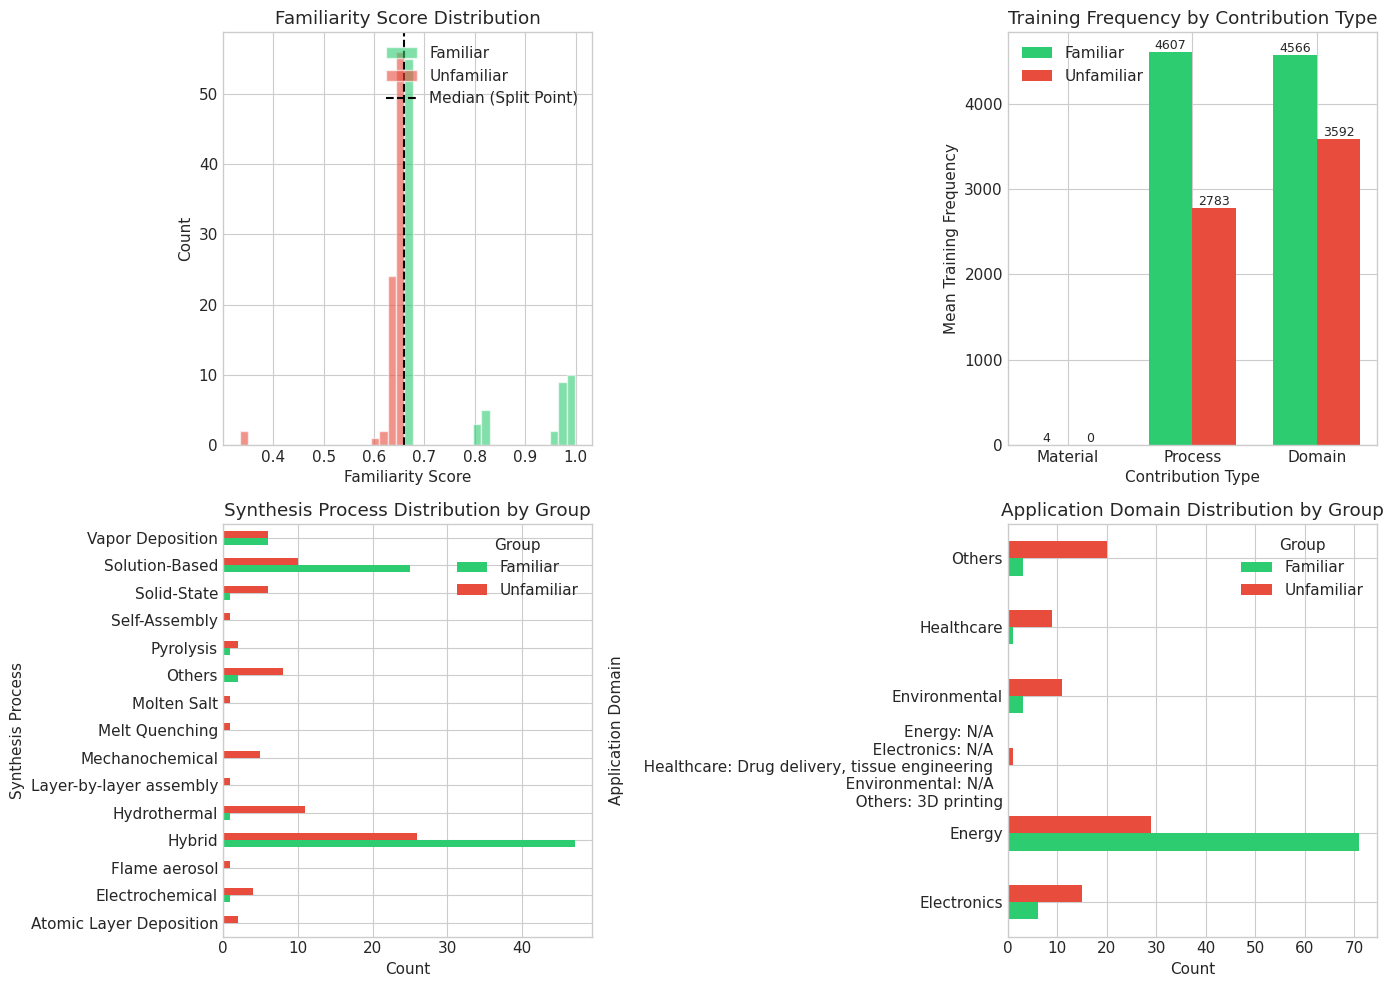

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Familiarity Score Distribution
ax1 = axes[0, 0]
colors = {'Familiar': '#2ecc71', 'Unfamiliar': '#e74c3c'}
for group in ['Familiar', 'Unfamiliar']:
    group_data = combined_df[combined_df['group'] == group]['familiarity_score']
    ax1.hist(group_data, bins=20, alpha=0.6, label=group, color=colors[group], edgecolor='white')
ax1.axvline(combined_df['familiarity_score'].median(), color='black', linestyle='--', label='Median (Split Point)')
ax1.set_xlabel('Familiarity Score')
ax1.set_ylabel('Count')
ax1.set_title('Familiarity Score Distribution')
ax1.legend()

# 2. Score by Component
ax2 = axes[0, 1]
score_cols = ['material_freq', 'process_freq', 'domain_freq']
score_labels = ['Material', 'Process', 'Domain']
x = np.arange(len(score_labels))
width = 0.35

familiar_means = [familiar_df[col].mean() for col in score_cols]
unfamiliar_means = [unfamiliar_df[col].mean() for col in score_cols]

bars1 = ax2.bar(x - width/2, familiar_means, width, label='Familiar', color='#2ecc71')
bars2 = ax2.bar(x + width/2, unfamiliar_means, width, label='Unfamiliar', color='#e74c3c')
ax2.set_xlabel('Contribution Type')
ax2.set_ylabel('Mean Training Frequency')
ax2.set_title('Training Frequency by Contribution Type')
ax2.set_xticks(x)
ax2.set_xticklabels(score_labels)
ax2.legend()

# Add value labels
for bar in bars1:
    ax2.annotate(f'{bar.get_height():.0f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax2.annotate(f'{bar.get_height():.0f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=9)

# 3. Process Distribution
ax3 = axes[1, 0]
process_counts = combined_df.groupby(['process', 'group']).size().unstack(fill_value=0)
process_counts = process_counts.reindex(columns=['Familiar', 'Unfamiliar'])
process_counts.plot(kind='barh', ax=ax3, color=['#2ecc71', '#e74c3c'])
ax3.set_xlabel('Count')
ax3.set_ylabel('Synthesis Process')
ax3.set_title('Synthesis Process Distribution by Group')
ax3.legend(title='Group')

# 4. Domain Distribution
ax4 = axes[1, 1]
domain_counts = combined_df.groupby(['domain', 'group']).size().unstack(fill_value=0)
domain_counts = domain_counts.reindex(columns=['Familiar', 'Unfamiliar'])
domain_counts.plot(kind='barh', ax=ax4, color=['#2ecc71', '#e74c3c'])
ax4.set_xlabel('Count')
ax4.set_ylabel('Application Domain')
ax4.set_title('Application Domain Distribution by Group')
ax4.legend(title='Group')

plt.tight_layout()
plt.savefig('familiarity_bias_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2798955/2866132137.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='group', y=col, ax=ax, palette=['#2ecc71', '#e74c3c'])
/tmp/ipykernel_2798955/2866132137.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='group', y=col, ax=ax, palette=['#2ecc71', '#e74c3c'])
/tmp/ipykernel_2798955/2866132137.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='group', y=col, ax=ax, palette=['#2ecc71', '#e74c3c'])


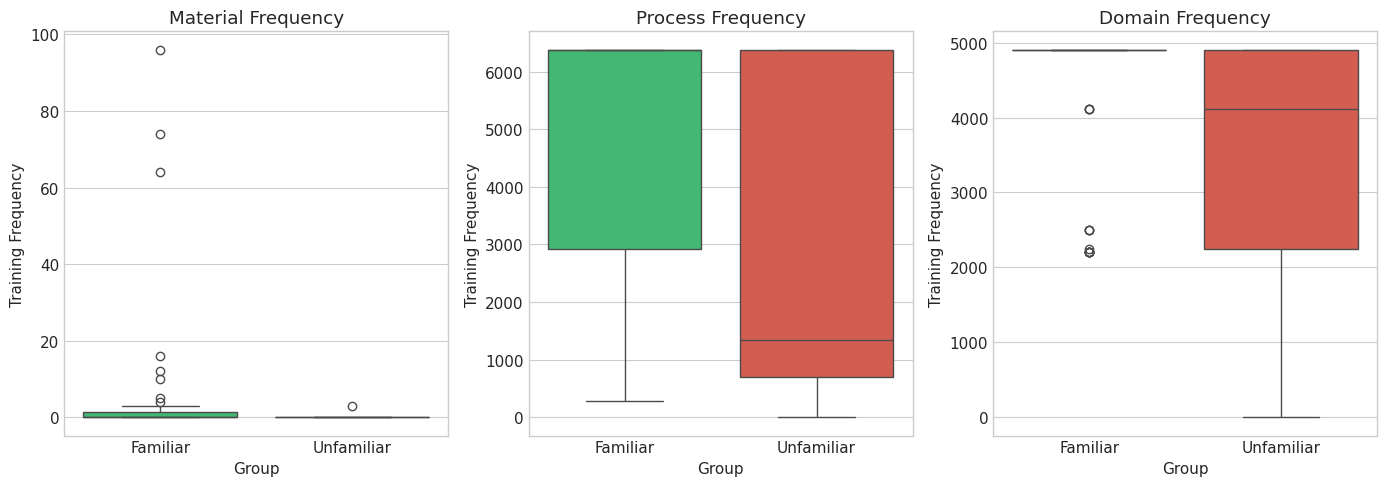

In [18]:
# Detailed boxplot comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for i, (col, label) in enumerate(zip(score_cols, score_labels)):
    ax = axes[i]
    sns.boxplot(data=combined_df, x='group', y=col, ax=ax, palette=['#2ecc71', '#e74c3c'])
    ax.set_xlabel('Group')
    ax.set_ylabel('Training Frequency')
    ax.set_title(f'{label} Frequency')

plt.tight_layout()
plt.savefig('familiarity_bias_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

## 5.1 Familiarity Heatmap

Visualize training frequency for each test instance across Material, Process, and Domain.
Each row represents a test sample, sorted by total familiarity score.

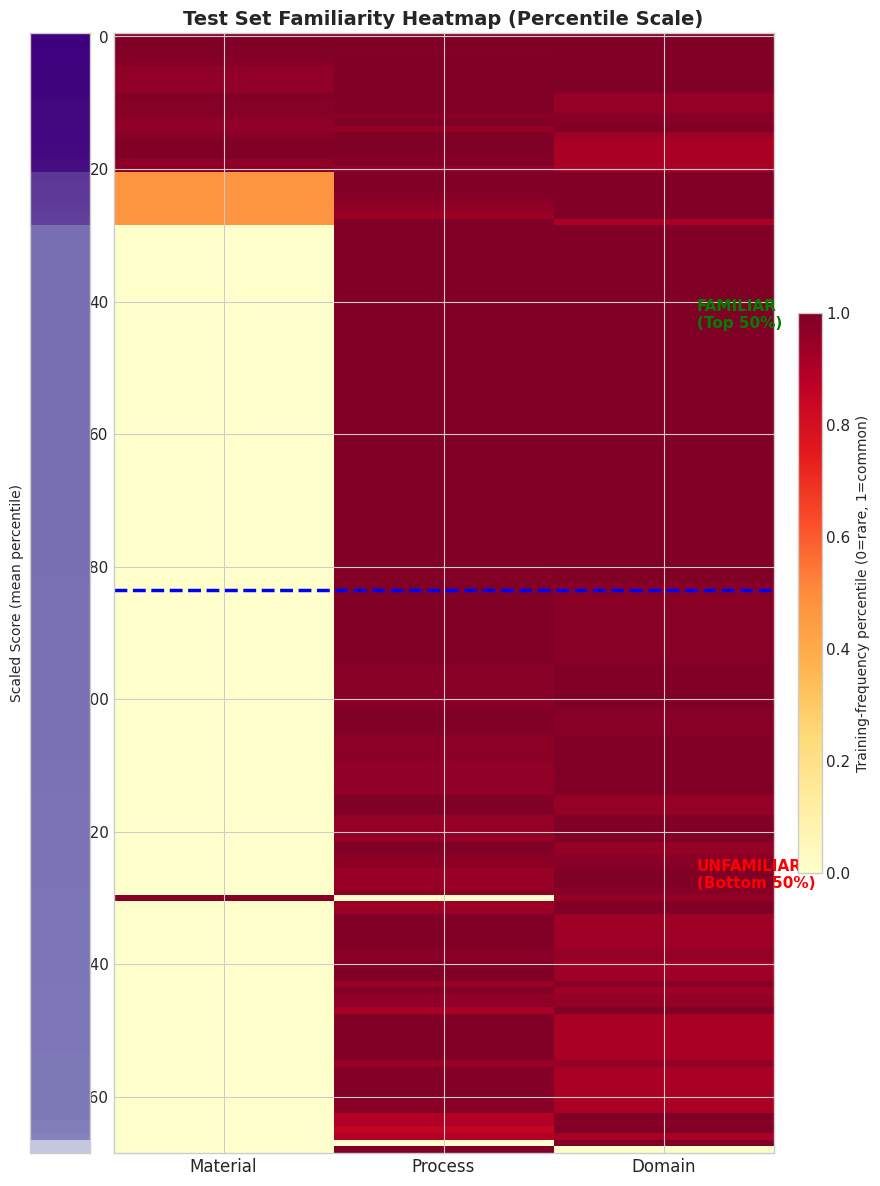

KEY INSIGHTS FROM SCALED HEATMAP

Familiar Group (Top 50%, n=84):
  Material pct > 0: 29/84 (34.5%)
  Process pct > 0: 84/84 (100.0%)
  Domain pct > 0: 84/84 (100.0%)

Unfamiliar Group (Bottom 50%, n=85):
  Material pct > 0: 1/85 (1.2%)
  Process pct > 0: 83/85 (97.6%)
  Domain pct > 0: 84/85 (98.8%)


In [21]:
# Build scaled (percentile) matrix for heatmap
# Assumes `train_pct` is prepared: train_pct[col][value] -> percentile in [0, 1]
scaled_matrix = []
for _, row in test.iterrows():
    m = row['Material_Name']
    p = row['process']
    d = row['domain']
    scaled_matrix.append({
        'Material': train_pct['Material_Name'].get(m, 0.0) if pd.notna(m) else np.nan,
        'Process': train_pct['process'].get(p, 0.0) if pd.notna(p) else np.nan,
        'Domain': train_pct['domain'].get(d, 0.0) if pd.notna(d) else np.nan,
    })

freq_heatmap_df = pd.DataFrame(scaled_matrix)

# Higher = more familiar. Use mean percentile across columns (ignoring NaNs).
freq_heatmap_df['Total'] = freq_heatmap_df[['Material', 'Process', 'Domain']].mean(axis=1, skipna=True)
freq_heatmap_df = freq_heatmap_df.sort_values('Total', ascending=False).reset_index(drop=True)

# Create figure with percentile-scale heatmap
fig = plt.figure(figsize=(12, 14))
ax_main = fig.add_axes([0.15, 0.1, 0.55, 0.8])

vals = freq_heatmap_df[['Material', 'Process', 'Domain']].values
im = ax_main.imshow(vals, cmap='YlOrRd', aspect='auto', vmin=0.0, vmax=1.0)

ax_main.set_xticks([0, 1, 2])
ax_main.set_xticklabels(['Material', 'Process', 'Domain'], fontsize=12)
ax_main.set_ylabel('Test Samples (sorted by scaled familiarity score)', fontsize=12)
ax_main.set_title('Test Set Familiarity Heatmap (Percentile Scale)', fontsize=14, fontweight='bold')

# Add colorbar
cbar_ax = fig.add_axes([0.72, 0.3, 0.02, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Training-frequency percentile (0=rare, 1=common)', fontsize=10)

# Add 50% split line
split_idx = len(freq_heatmap_df) // 2
ax_main.axhline(y=split_idx - 0.5, color='blue', linestyle='--', linewidth=2.5)

# Add annotations
ax_main.text(2.15, split_idx/2, 'FAMILIAR\n(Top 50%)', fontsize=11, va='center',
             color='green', fontweight='bold', ha='left')
ax_main.text(2.15, split_idx + (len(freq_heatmap_df)-split_idx)/2, 'UNFAMILIAR\n(Bottom 50%)',
             fontsize=11, va='center', color='red', fontweight='bold', ha='left')

# Side bar showing total score
ax_side = fig.add_axes([0.08, 0.1, 0.05, 0.8])
total_scores = freq_heatmap_df['Total'].values.reshape(-1, 1)
ax_side.imshow(total_scores, cmap='Purples', aspect='auto', vmin=0.0, vmax=1.0)
ax_side.set_xticks([])
ax_side.set_yticks([])
ax_side.set_ylabel('Scaled Score (mean percentile)', fontsize=10)

plt.savefig('familiarity_heatmap_scaled.png', dpi=150, bbox_inches='tight')
plt.show()

# Print key insights (scaled)
print("=" * 60)
print("KEY INSIGHTS FROM SCALED HEATMAP")
print("=" * 60)
familiar = freq_heatmap_df.iloc[:split_idx]
unfamiliar = freq_heatmap_df.iloc[split_idx:]

print(f"\nFamiliar Group (Top 50%, n={len(familiar)}):")
print(f"  Material pct > 0: {(familiar['Material'] > 0).sum()}/{len(familiar)} ({(familiar['Material'] > 0).mean()*100:.1f}%)")
print(f"  Process pct > 0: {(familiar['Process'] > 0).sum()}/{len(familiar)} ({(familiar['Process'] > 0).mean()*100:.1f}%)")
print(f"  Domain pct > 0: {(familiar['Domain'] > 0).sum()}/{len(familiar)} ({(familiar['Domain'] > 0).mean()*100:.1f}%)")

print(f"\nUnfamiliar Group (Bottom 50%, n={len(unfamiliar)}):")
print(f"  Material pct > 0: {(unfamiliar['Material'] > 0).sum()}/{len(unfamiliar)} ({(unfamiliar['Material'] > 0).mean()*100:.1f}%)")
print(f"  Process pct > 0: {(unfamiliar['Process'] > 0).sum()}/{len(unfamiliar)} ({(unfamiliar['Process'] > 0).mean()*100:.1f}%)")
print(f"  Domain pct > 0: {(unfamiliar['Domain'] > 0).sum()}/{len(unfamiliar)} ({(unfamiliar['Domain'] > 0).mean()*100:.1f}%)")

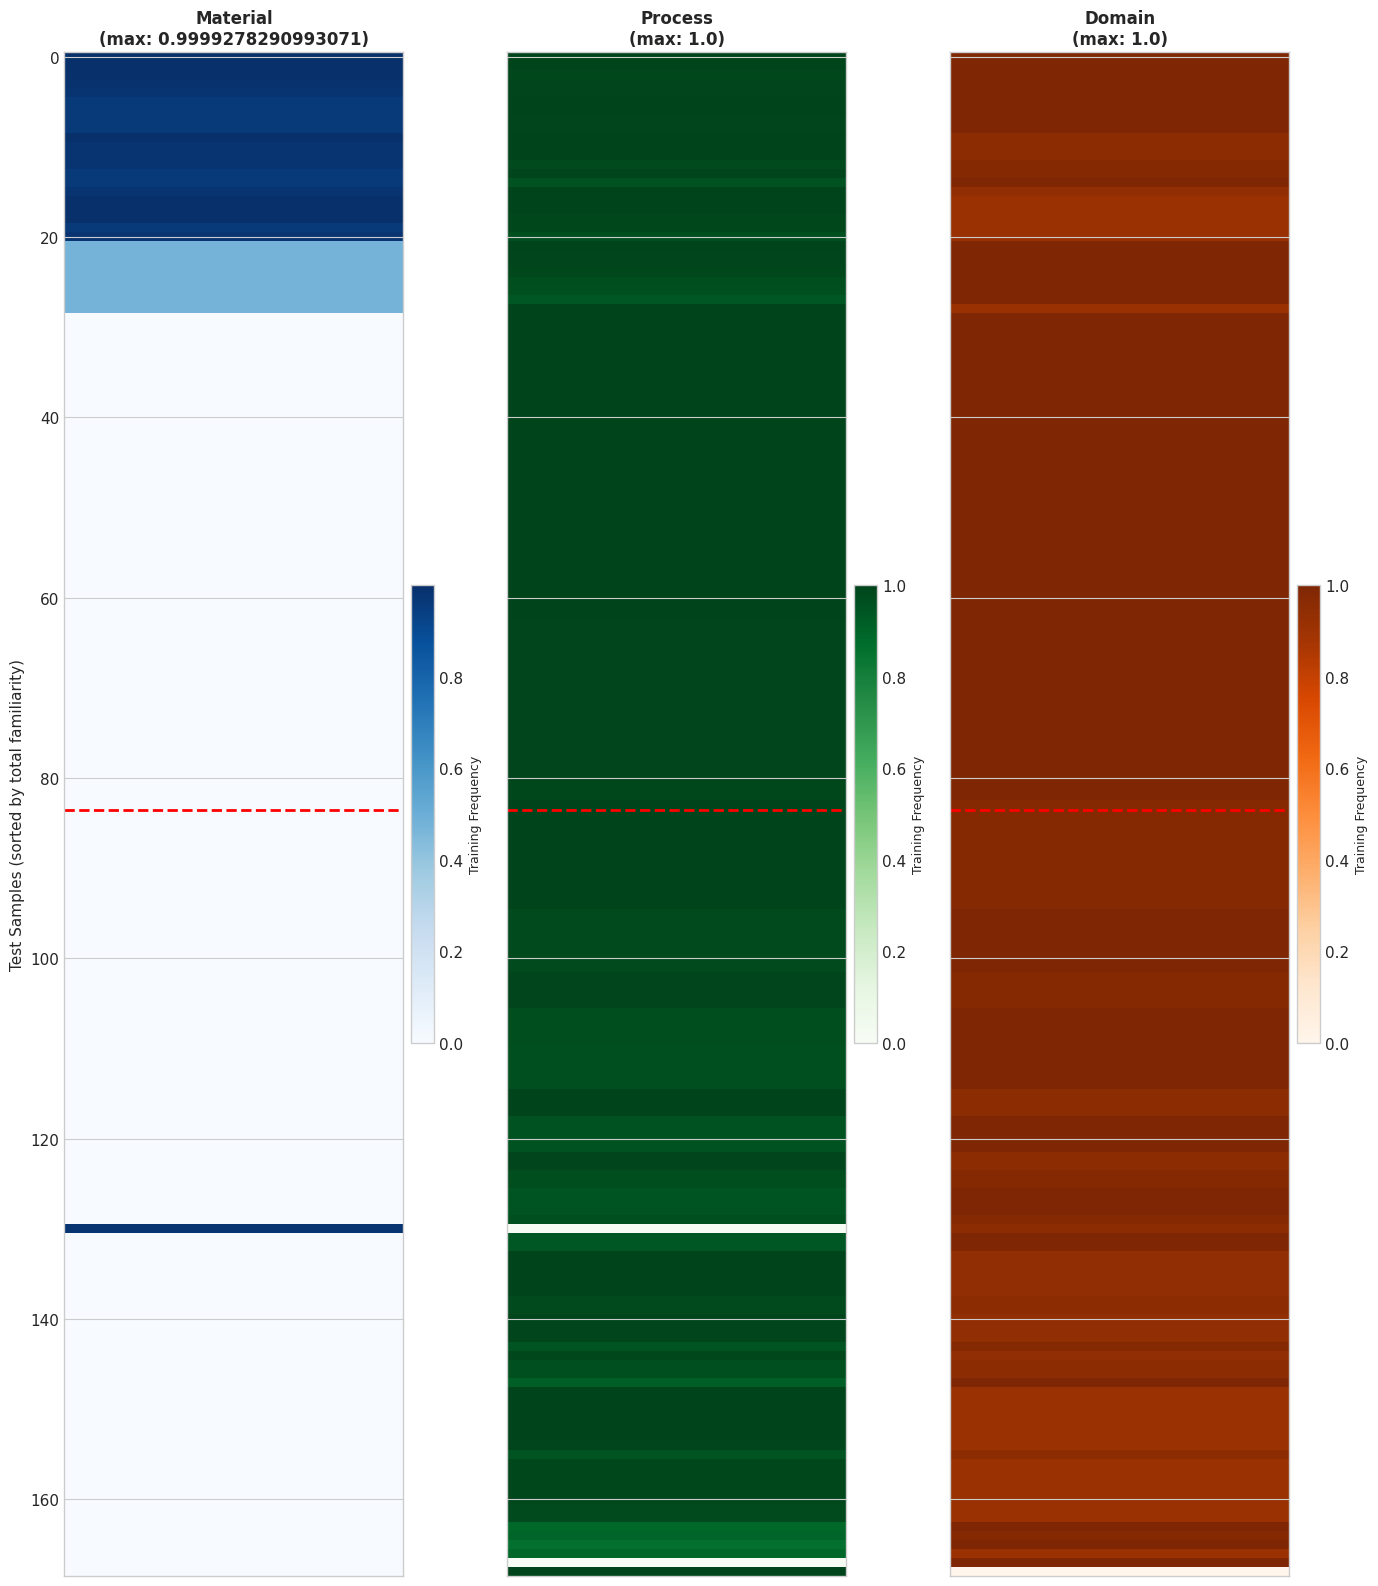

Heatmap shows clear pattern:
  - Material: Almost all samples have 0 frequency (novel materials)
  - Process: Sharp divide - Familiar group dominated by Hybrid (dark green)
  - Domain: More uniform distribution across both groups


In [23]:
# Raw values heatmap - separate panels for each component
fig, axes = plt.subplots(1, 3, figsize=(14, 16), sharey=True)

cols = ['Material', 'Process', 'Domain']
cmaps = ['Blues', 'Greens', 'Oranges']
maxvals = [freq_heatmap_df[col].max() for col in cols]

for i, (col, cmap, maxval) in enumerate(zip(cols, cmaps, maxvals)):
    data = freq_heatmap_df[[col]].values
    
    im = axes[i].imshow(
        data,
        cmap=cmap,
        aspect='auto',
        vmin=0,
        vmax=maxval if maxval > 0 else 1
    )
    
    axes[i].set_title(f'{col}\n(max: {maxval:,})', fontsize=12, fontweight='bold')
    axes[i].set_xticks([])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i], shrink=0.3, pad=0.02)
    cbar.set_label('Training Frequency', fontsize=9)
    
    # Add split line
    split_idx = len(freq_heatmap_df) // 2
    axes[i].axhline(y=split_idx - 0.5, color='red', linestyle='--', linewidth=2)

axes[0].set_ylabel('Test Samples (sorted by total familiarity)', fontsize=11)

# plt.suptitle('Test Set Training Frequency by Component (Raw Values)', fontsize=14, fontweight='bold', y=0.92)
plt.tight_layout()
plt.savefig('familiarity_heatmap_raw.png', dpi=150, bbox_inches='tight')
plt.show()

print("Heatmap shows clear pattern:")
print("  - Material: Almost all samples have 0 frequency (novel materials)")
print("  - Process: Sharp divide - Familiar group dominated by Hybrid (dark green)")
print("  - Domain: More uniform distribution across both groups")

## 6. Summary Statistics

In [12]:
# Summary table
summary = combined_df.groupby('group').agg({
    'familiarity_score': ['count', 'mean', 'std', 'min', 'max'],
    'material_freq': 'mean',
    'process_freq': 'mean',
    'domain_freq': 'mean'
}).round(2)

summary.columns = ['Count', 'Mean Score', 'Std', 'Min', 'Max', 'Avg Material Freq', 'Avg Process Freq', 'Avg Domain Freq']
summary

,Count,Mean Score,Std,Min,Max,Avg Material Freq,Avg Process Freq,Avg Domain Freq
group,,,,,,,,
Familiar,84,10030.17,1393.55,7818,11300,1.99,5887.29,4140.89
Unfamiliar,85,5531.52,1428.99,2232,7818,1.85,1517.69,4011.98


In [13]:
# Save split results
combined_df.to_csv('test_high_impact_familiarity_split.csv', index=False)
print("Saved to: test_high_impact_familiarity_split.csv")

# Save IDs for each group
familiar_ids = familiar_df['id'].tolist()
unfamiliar_ids = unfamiliar_df['id'].tolist()

import json
with open('familiarity_split_ids.json', 'w') as f:
    json.dump({
        'familiar': familiar_ids,
        'unfamiliar': unfamiliar_ids
    }, f, indent=2)
print("Saved to: familiarity_split_ids.json")

Saved to: test_high_impact_familiarity_split.csv
Saved to: familiarity_split_ids.json


## 7. Detailed Component Analysis

In [14]:
# Materials that appear in test but NOT in training (zero-shot)
test_materials = set(test['Material_Name'].dropna())
train_materials = set(train['Material_Name'].dropna())

novel_materials = test_materials - train_materials
familiar_materials = test_materials & train_materials

print(f"=== Material Analysis ===")
print(f"Unique materials in test: {len(test_materials)}")
print(f"Novel materials (not in train): {len(novel_materials)} ({len(novel_materials)/len(test_materials)*100:.1f}%)")
print(f"Familiar materials (in train): {len(familiar_materials)} ({len(familiar_materials)/len(test_materials)*100:.1f}%)")

print(f"\nNovel materials examples:")
for m in list(novel_materials)[:5]:
    print(f"  - {m}")

=== Material Analysis ===
Unique materials in test: 167
Novel materials (not in train): 139 (83.2%)
Familiar materials (in train): 28 (16.8%)

Novel materials examples:
  - BODIPY-based Zirconium Metal-Organic Framework (69-L2)
  - Poly(ether-urethane)-based solid-state polymer electrolyte
  - Luminescent polymers
  - Conductive biofilament doped with Bi2O3 and CuO
  - Lithium-rich layered oxide (AS200)


In [15]:
# Process and Domain coverage
for col, name in [('process', 'Synthesis Process'), ('domain', 'Application Domain')]:
    test_vals = set(test[col].dropna())
    train_vals = set(train[col].dropna())
    novel = test_vals - train_vals
    
    print(f"\n=== {name} ===")
    print(f"Test set values: {test_vals}")
    print(f"Novel (not in train): {novel if novel else 'None'}")


=== Synthesis Process ===
Test set values: {'Flame aerosol', 'Electrochemical', 'Molten Salt', 'Solid-State', 'Others', 'Self-Assembly', 'Melt Quenching', 'Solution-Based', 'Atomic Layer Deposition', 'Layer-by-layer assembly', 'Hydrothermal', 'Pyrolysis', 'Mechanochemical', 'Vapor Deposition', 'Hybrid'}
Novel (not in train): {'Flame aerosol', 'Layer-by-layer assembly'}

=== Application Domain ===
Test set values: {'Healthcare', 'Others', 'Energy', 'Electronics', 'Environmental', 'Energy: N/A  \n   Electronics: N/A  \n   Healthcare: Drug delivery, tissue engineering  \n   Environmental: N/A  \n   Others: 3D printing'}
Novel (not in train): {'Energy: N/A  \n   Electronics: N/A  \n   Healthcare: Drug delivery, tissue engineering  \n   Environmental: N/A  \n   Others: 3D printing'}
